In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Task 1: Data Understanding and Visualization

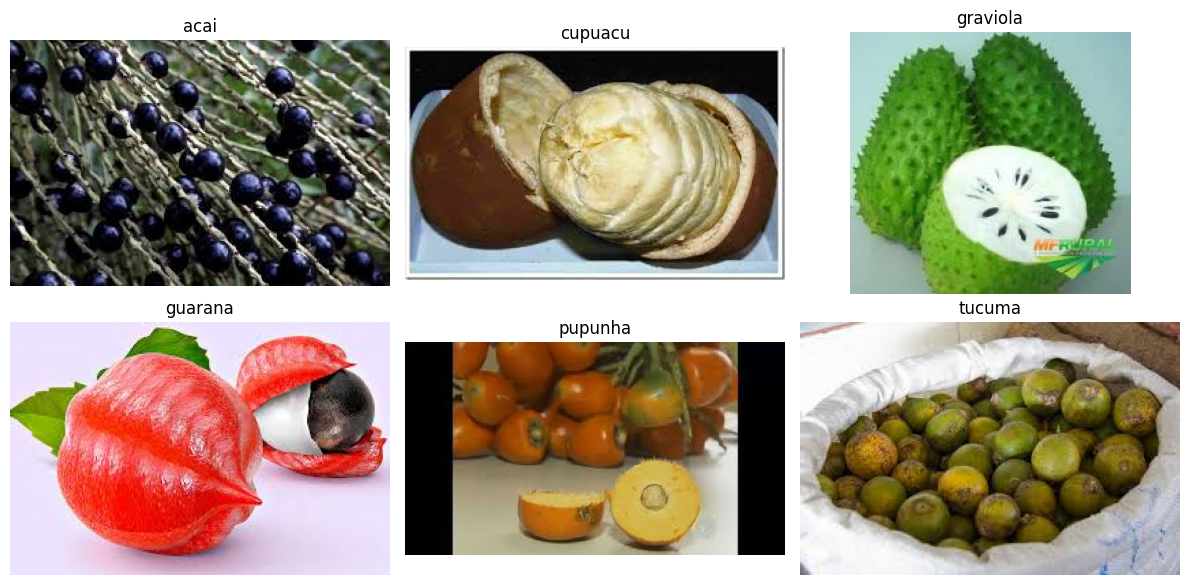

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import random

# Training and testing directory
train_dir = "/content/drive/MyDrive/AI and ML Final Sem/Workshop 5/FruitinAmazon/train"

test_dir = "/content/drive/MyDrive/AI and ML Final Sem/Workshop 5/FruitinAmazon/test"

img_height, img_width = 128, 128  # Increased resolution

# Get the list of class directories
class_names = os.listdir(train_dir)

# Select one image randomly from each class
selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        if image_files:
            selected_image = random.choice(image_files)
            selected_images.append((class_name, os.path.join(class_path, selected_image)))

# Display the images in a grid format with two rows
fig, axes = plt.subplots(nrows=2, ncols=(len(selected_images) + 1) // 2, figsize=(12, 6))

for ax, (class_name, image_path) in zip(axes.flat, selected_images):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Check for Corrupted Image

In [ ]:
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                # Attempt to open the image
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image is valid

            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)  # Remove the corrupted image
                print(f"Removed corrupted image: {image_path}")

# Print the result
if not corrupted_images:
    print("No corrupted images found.")

No corrupted images found.


# Task 2: Loading and Preprocessing Image Data in keras

In [ ]:
# Define image size and batch size
img_height = 128
img_width = 128
batch_size = 32
validation_split=0.2 #80% training , 20% validation
# Create preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0,1]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
    )

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.


Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


# Task 3 - Implement a CNN with

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the number of classes dynamically based on the dataset
num_classes = len(class_names)  # Assuming `class_names` is already defined

# Build the CNN model
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=1, activation="relu",
                  input_shape=(img_height, img_width, 3)),  # 3 for RGB images
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=1, activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers (Hidden Layers)
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),

    # Output Layer
    layers.Dense(num_classes, activation="softmax")  # Softmax for multi-class classification
])

# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# Task 4: Compile the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(
    optimizer="adam",  # Adam optimizer
    loss="sparse_categorical_crossentropy",  # Suitable for integer-labeled classes
    metrics=["accuracy"]  # Evaluation metric
)

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),  # Save best model
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)  # Stop early if no improvement
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Train for 250 epochs
    batch_size=16,  # Batch size of 16
    callbacks=callbacks  # Apply callbacks
)


Epoch 1/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9699 - loss: 0.1721

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.9705 - loss: 0.1684 - val_accuracy: 0.8889 - val_loss: 0.1932
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.8333 - val_loss: 0.6058
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8889 - val_loss: 0.5696
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 0.8889 - val_loss: 0.3182
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.8889 - val_loss: 0.3125
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.8889 - val_loss: 0.3064
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.9891 - loss: 0.0208 - val_accuracy: 0.8333 - val_loss: 0.7204
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8889 - val_loss: 1.2337
Epo

In [ ]:
# Load the test dataset (without shuffling)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/AI and ML Final Sem/Workshop 5/FruitinAmazon/test",  # Update with the actual test dataset path
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=False
).map(lambda x, y: (rescale(x), y))  # Apply normalization


Found 30 files belonging to 6 classes.


# Task 5: Evaluate the Model

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print test results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7667 - loss: 0.8487
Test Accuracy: 76.67%
Test Loss: 0.8487


# Task 6: Save and Load the Model

In [ ]:
# Save the trained model in the recommended format
model.save("fruit_classification_model.keras")
print("Model saved successfully!")

Model saved successfully!


# Task 7: Predictions and Classification Report

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Recompile the model with sparse_categorical_crossentropy if labels are integers
loaded_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now evaluate the model
test_loss, test_accuracy = loaded_model.evaluate(test_ds)

# Print the results
print(f"Test Loss (after reloading): {test_loss}")
print(f"Test Accuracy (after reloading): {test_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.7667 - loss: 60.7761
Test Loss (after reloading): 60.77605438232422
Test Accuracy (after reloading): 0.7666666507720947


In [ ]:
from sklearn.metrics import classification_report

# Get class names from the directory structure
class_names = sorted(os.listdir(test_dir))  # List of class names

# Get the test dataset (make sure it's in the same format as train_ds)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Get true labels from the test dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Make predictions on the test dataset
predictions = loaded_model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)

# Ensure true_labels and predicted_labels are 1D arrays
true_labels = true_labels.flatten()
predicted_labels = predicted_labels.flatten()

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

Found 30 files belonging to 6 classes.


2025-04-03 09:00:57.347071: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
              precision    recall  f1-score   support

        acai       0.71      1.00      0.83         5
     cupuacu       0.75      0.60      0.67         5
    graviola       0.62      1.00      0.77         5
     guarana       1.00      0.60      0.75         5
     pupunha       0.83      1.00      0.91         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.77        30
   macro avg       0.82      0.77      0.75        30
weighted avg       0.82      0.77      0.75        30

